In [103]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, Matern
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import norm
import scipy
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc

import matplotlib.pyplot as plt 
import seaborn as sns

In [7]:
hws= pd.read_hdf('/home/gorilla/An/data/Sprints/HighRes/Windy/WindyStatsTime_std.h5')

In [288]:
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')

In [289]:
def avg_distance(df,index,dat): #input ; location ; storage
  
    #Distance
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline
    # dat['log_avg_dist_from_source']= np.log10(dat.avg_dist_from_source)

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 2
np.seterr(divide='ignore')
index = osc.get_index(df.odor,th)
fdf = pd.DataFrame()

cal_stat(df,index,fdf)
avg_distance(df, index, fdf)
fdf.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time',
       'avg_distance_along_streakline', 'avg_nearest_from_streakline'],
      dtype='object')

In [267]:
df_train = df[:22000]
df_test = df[22000:]

query = 'odor>2'
df_train = df_train.query(query)
df_train.reset_index(inplace=True, drop=True)
df_test = df_test.query(query)
df_test.reset_index(inplace=True, drop=True)

In [286]:
distance_threshold = 0.4
test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
# Calculate distances between test locations and whiff start locations
# distances = cdist([df_test.distance_along_streakline, df_test.nearest_from_streakline], whiff_locations)
distances = cdist(test_locations, whiff_locations)
whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values

odor_concentration_samples = []

Loop through test locations and generate odor concentrations based on nearest whiff
for i, location in enumerate(test_locations):
    if np.min(distances[i]) <= distance_threshold:
        nearest_whiff_idx = np.argmin(distances[i])
        mean_concentration = whiff_means[nearest_whiff_idx]
        std_concentration = whiff_stds[nearest_whiff_idx]

        generated_concentration = np.random.normal(mean_concentration, std_concentration)

        # Clip the predicted concentration to be within the range [0, 10]
        generated_concentration = np.clip(generated_concentration, 1, 10.2)
    else:
        generated_concentration = np.nan  # No whiff within threshold

    # Append the generated concentration for the test location
    odor_concentration_samples.append(generated_concentration)

# Add new column to df_test
df_test['predicted_odor'] = odor_concentration_samples

# for i, location in enumerate(test_locations):
#     if np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_concentration = whiff_stds[nearest_whiff_idx]

#         # Use the mean concentration to set the scale for the exponential distribution
#         lambda_value = 1 / mean_concentration if mean_concentration != 0 else 1
#         generated_concentration = np.random.exponential(scale=1/lambda_value, size=1)[0]

#         # Clip the predicted concentration to be within the range [0, 10]
#         generated_concentration = np.clip(generated_concentration, 0, 10)
#     else:
#         generated_concentration = np.nan  # No whiff within threshold

#     # Append the generated concentration for the test location
#     odor_concentration_samples.append(generated_concentration)

# # Add the predicted odor concentrations to df_test
# df_test['predicted_odor'] = odor_concentration_samples


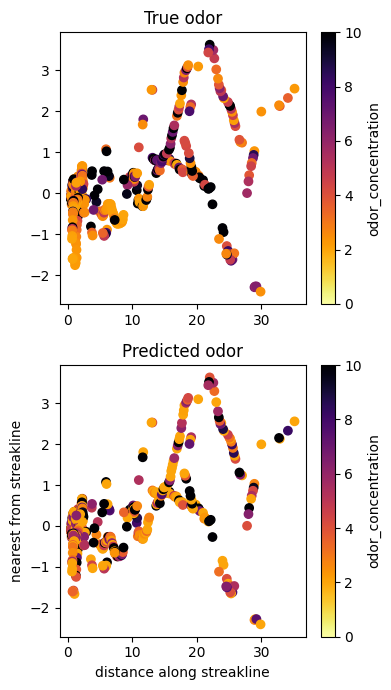

In [282]:
f,(ax1,ax2)=plt.subplots(2,1,figsize=(4,7))
cax1 =ax1.scatter(df_test.distance_along_streakline, df_test.nearest_from_streakline, c=df_test.odor, cmap='inferno_r', vmin=0, vmax=10)
cax = ax2.scatter(df_test.distance_along_streakline, df_test.nearest_from_streakline, c=df_test.predicted_odor, cmap='inferno_r', vmin=0, vmax=10)
ax2.set_xlabel('distance along streakline')
ax2.set_ylabel('nearest from streakline')
ax1.set_title('True odor')
ax2.set_title('Predicted odor')
plt.colorbar(cax, label='odor_concentration')
plt.colorbar(cax1, label='odor_concentration')

f.tight_layout()


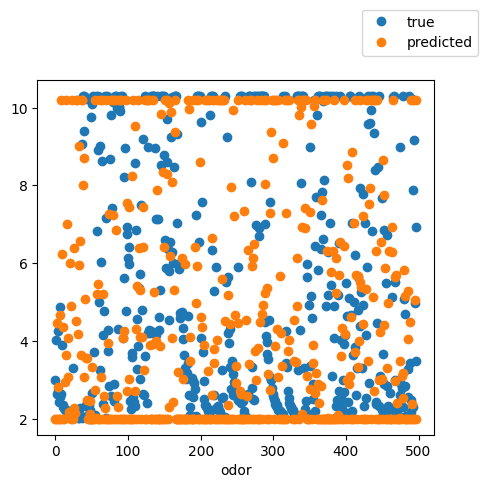

In [283]:
f,ax=plt.subplots(figsize=(5,5))
ax.plot(df_test.odor, 'o', label='true')
ax.plot(df_test.predicted_odor, 'o', label='predicted')
ax.set_xlabel('odor')

ax.legend(bbox_to_anchor=(0.8, 1.05))
f.tight_layout()

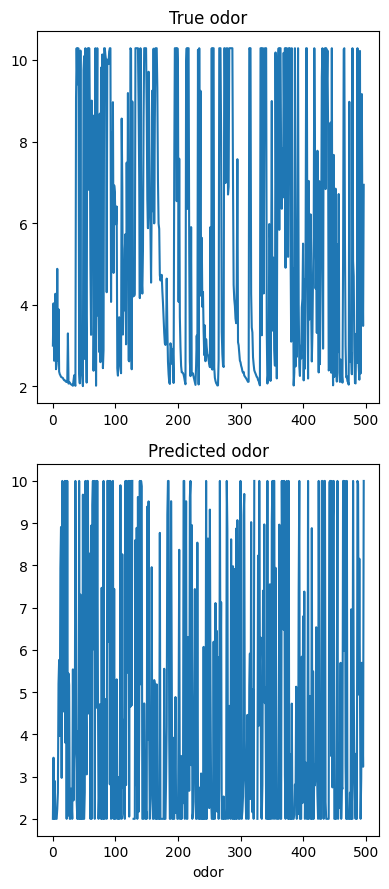

In [277]:
f,(ax1,ax2)=plt.subplots(2,1,figsize=(4,9))
ax1.plot(df_test.odor)
ax2.plot(df_test.predicted_odor)
ax2.set_xlabel('odor')
# ax2.set_xlabel('nearest from streakline')
ax1.set_title('True odor')
ax2.set_title('Predicted odor')
f.tight_layout()


In [278]:
new_test_df = df_test.copy()

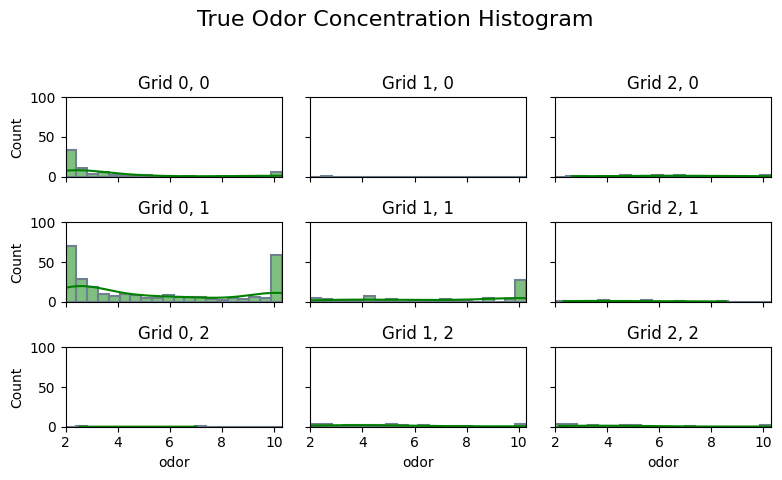

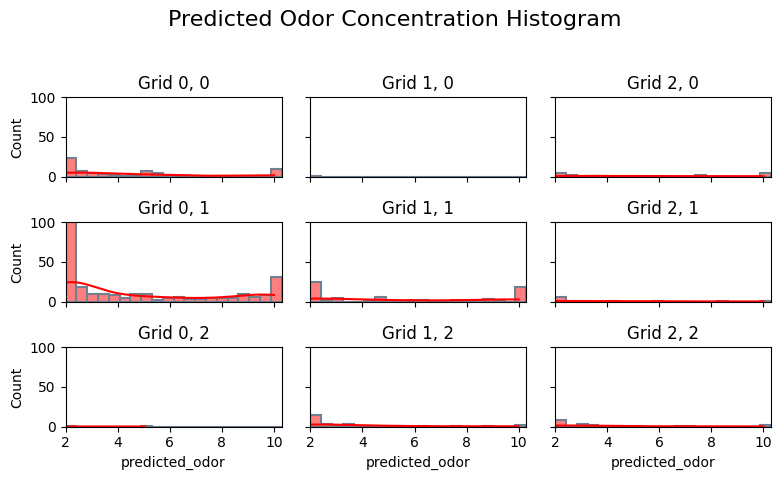

In [280]:
# Define the number of bins for the grid
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)
# Determine global range for histogram bins
global_min = new_test_df[['odor', 'predicted_odor']].min().min()
global_max = new_test_df[['odor', 'predicted_odor']].max().max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

# Define specific x-axis limitsdf_test
specific_x_min = global_min
specific_x_max = global_max
ylim=[0,100]
# Plot histograms for true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actualdf_test data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


# Plot histograms for predicted odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['predicted_odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='red', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Predicted Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [290]:
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

# Function to perform nearest whiff mapping for a single train-test chunk
def train_and_test_nearest_whiff(fdf, df_test_chunk, distance_threshold=0.4):
    # Get whiff start locations, means, and stds from the external fdf dataframe
    whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
    whiff_means = fdf['mean_concentration'].values
    whiff_stds = fdf['std_whiff'].values

    # Get test locations
    test_locations = df_test_chunk[['distance_along_streakline', 'nearest_from_streakline']].values

    # Calculate distances between test locations and whiff start locations
    distances = cdist(test_locations, whiff_locations)

    odor_concentration_samples = []

    # Loop through test locations and generate odor concentrations based on nearest whiff
    for i, location in enumerate(test_locations):
        if np.min(distances[i]) <= distance_threshold:
            nearest_whiff_idx = np.argmin(distances[i])
            mean_concentration = whiff_means[nearest_whiff_idx]
            std_concentration = whiff_stds[nearest_whiff_idx]

            generated_concentration = np.random.normal(mean_concentration, std_concentration)

            # Clip the predicted concentration to be within the range [0, 10]
            generated_concentration = np.clip(generated_concentration, 1, 10.2)
        else:
            generated_concentration = np.nan  # No whiff within threshold

        # Append the generated concentration for the test location
        odor_concentration_samples.append(generated_concentration)

    # Add new column to df_test_chunk
    df_test_chunk['predicted_odor'] = odor_concentration_samples

    return df_test_chunk


# Load your data
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')

output_dfs = []

n_iterations = 2  # Number of iterations
total_length = len(df)
test_size = 5000  # Size of the test chunk

for iteration in range(n_iterations):
    # Randomly select a chunk for testing
    test_start = np.random.randint(0, total_length - test_size)
    test_end = test_start + test_size

    # Define the training chunks excluding the selected test chunk
    train_chunks = [
        (0, test_start),
        (test_end, total_length)
    ]

    # Apply the query filter to train and test chunks
    df_train_chunk = pd.concat([df.iloc[start:end].query('odor >= 2') for start, end in train_chunks], ignore_index=True)
    df_train_chunk.reset_index(inplace=True, drop=True)

    df_test_chunk = df.iloc[test_start:test_end].query('odor >= 2').reset_index(drop=True)

    # Perform the nearest whiff prediction method for this chunk using fdf
    test_results = train_and_test_nearest_whiff(fdf, df_test_chunk)

    # Store the results in a separate DataFrame for each iteration
    output_dfs.append(test_results)

# The output_dfs list now contains DataFrames for each iteration
output_1, output_2 = output_dfs

# # Example: Concatenate all the output data frames
# final_df = pd.concat(output_dfs, ignore_index=True)
# print(final_df[['distance_along_streakline', 'nearest_from_streakline', 'predicted_odor']])


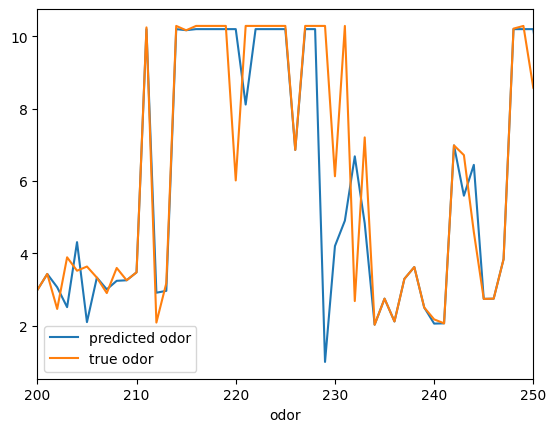

In [299]:
plt.plot(output_1.predicted_odor, label= 'predicted odor')
plt.plot(output_1.odor, label = 'true odor')
plt.xlim(200,250)
plt.xlabel('odor')
plt.legend()

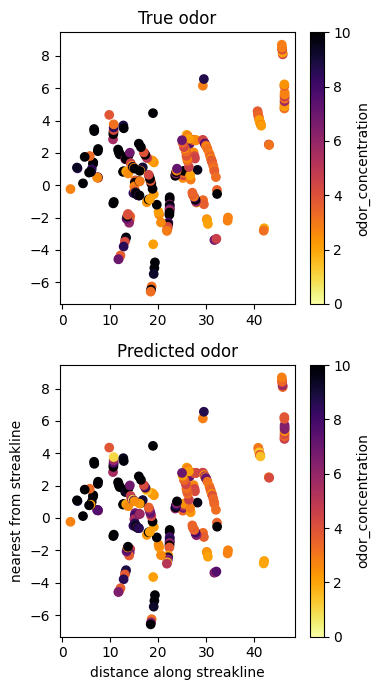

In [301]:
f,(ax1,ax2)=plt.subplots(2,1,figsize=(4,7))
cax1 =ax1.scatter(output_2.distance_along_streakline, output_2.nearest_from_streakline, c=output_2.odor, cmap='inferno_r', vmin=0, vmax=10)
cax = ax2.scatter(output_2.distance_along_streakline, output_2.nearest_from_streakline, c=output_2.predicted_odor, cmap='inferno_r', vmin=0, vmax=10)
ax2.set_xlabel('distance along streakline')
ax2.set_ylabel('nearest from streakline')
ax1.set_title('True odor')
ax2.set_title('Predicted odor')
plt.colorbar(cax, label='odor_concentration')
plt.colorbar(cax1, label='odor_concentration')

f.tight_layout()


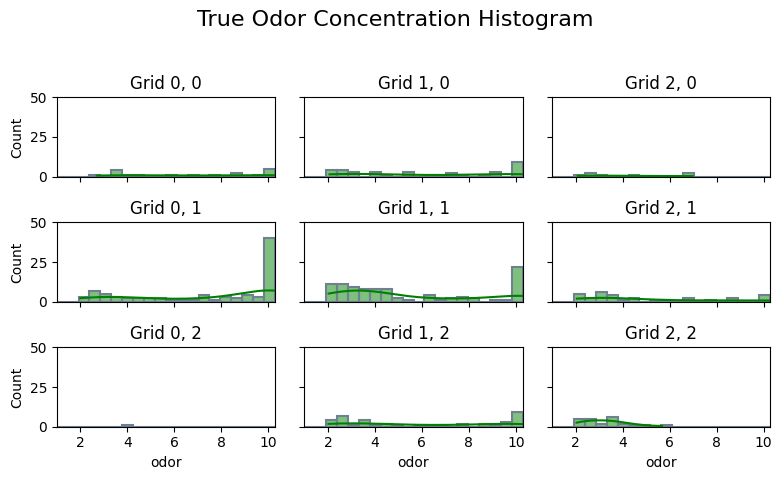

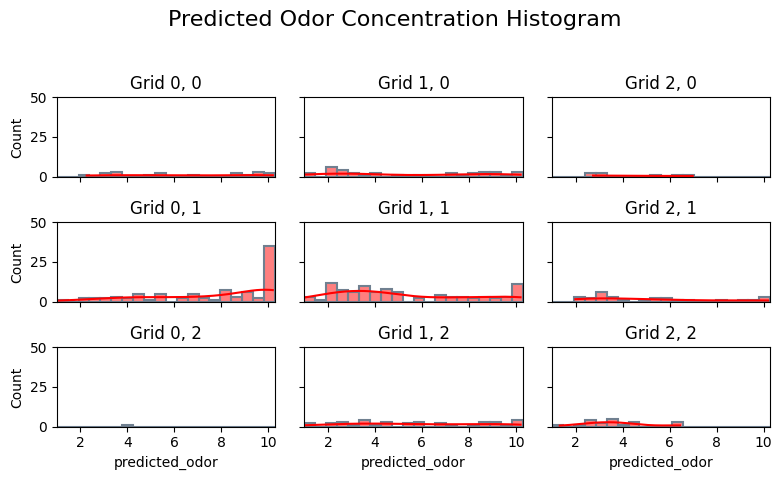

In [303]:
new_test_df=output_1.copy()
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)
# Determine global range for histogram bins
global_min = new_test_df[['odor', 'predicted_odor']].min().min()
global_max = new_test_df[['odor', 'predicted_odor']].max().max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

# Define specific x-axis limitsdf_test
specific_x_min = global_min
specific_x_max = global_max
ylim=[0,50]
# Plot histograms for true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actualdf_test data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


# Plot histograms for predicted odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['predicted_odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='red', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Predicted Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
